# Organization of code:

The code has been implemented using python class. There are three section in this code  
1) the Generalised Linear model class( a python class) : it has been internally divided into two parts, first is the bunch of functions which are common for all model and then, second, a bunch of functions that are model specific.  
2) supporting functions: there are number of functions which are written as helper functions, mainly includes, data division and plotting functions.  
3) Model execution part: Every model has been separately written for execution and should run one by one plotting all the required results.  

Note: two files this code has been provided, both are same code but one is ".py" file and another is ".ipynb" file. any one of them can be used for testing code.

# Generalised Linear Model 

Generalised linear model for  
    -- Logistic Regression  
    -- Poisson Regression  
    -- Ordinal Regression  


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import logistic as logit
import time
import matplotlib.pyplot as plt
%matplotlib inline

class GLM: # the GLM class
    
    ###### common operation for all models ########  
    
    def __init__(self, phi, labels, alpha_value, distribution_name, test_label, test_data):
        self.phi_matrix = np.insert(np.array(phi), 0, 1, axis=1) # added 1 at first column of phi for w0.
        self.label = np.array(labels) # the value R in second derivative.
        self.alpha = alpha_value
        self.method = distribution_name.lower()
        self.w_0 = np.zeros((np.shape(self.phi_matrix)[1],1))
        self.label_test = test_label
        self.phi_test = np.insert(np.array(test_data), 0, 1, axis=1)
        
    # this function will find the first derivating of the model and reutrn first derivative.
    def first_derivative(self, di: np.ndarray, w: np.ndarray) -> np.ndarray:
        return np.subtract(self.phi_matrix.transpose().dot(di), self.alpha*w)
     
    #this function will find the second derivative of model and return inverse of hassian.
    def second_derivative(self, ri: np.ndarray) -> np.ndarray:
        phit_R_phi = self.phi_matrix.transpose().dot(ri).dot(self.phi_matrix)
        hessian = np.add(phit_R_phi, self.alpha*(np.identity(len(phit_R_phi))))
        return np.linalg.inv(hessian)
     
    # this function will implement the newton-raphson method and return Wmap, 
    #number of iteration and convergence time.
    def newton_raphson(self, s=1) -> np.ndarray:
        start_time = time.time()
        w = self.w_0
        # N_R loop for convergance
        for itr in range(1,101): # for 100 iteration as specified in PP3
            w_old = w
            ri, di = self.yi_di_ri(w, s)
            derivative = self.first_derivative(di,w)
            hessian_inv = self.second_derivative(ri)
            w = w + hessian_inv.dot(derivative)
            if itr >1:
                mat = np.subtract(w, w_old)
                if np.linalg.norm(mat)/ np.linalg.norm(w_old) < 0.001:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time 
                elif itr == 100:
                    end_time = round(time.time()- start_time,4)
                    return w, itr, end_time            
          
        ############ Model based operation ############
        
    def yi_di_ri(self, w: np.ndarray, s=1) -> np.ndarray:
        # a_i = phi_tanspose.parameter_W
        ai = self.phi_matrix.dot(w).reshape(len(self.phi_matrix),1)
        ########## Logistic Regression #############
        # it will return the ri and di value for logistic regression.
        if self.method == "logistic":
            # yi = sigmoid function
            yi = 1/(1+ np.exp(-1*ai))
            di = np.subtract(self.label, yi) # (t-y)
            # R diag(yi(1- yi))
            ri = np.diagflat(yi*np.subtract(np.ones(np.shape(yi)), yi))
            return ri, di
        ######### Poission Regression ############
        # it will return the ri and di value for poisson regression.
        elif self.method == "poisson":
            # exponential function (exp(ai))
            yi = np.exp(ai) 
            di = np.subtract(self.label, yi) #(t-y)
            #R = diag(yi)
            ri = np.diagflat(yi)       
            return ri, di
      ########### Ordinal Regression ############
    # it will return the ri and di value for ordinal regression.
        elif self.method == "ordinal":      
            # Yij = column vectors yi0, yi1, yi2, yi3, yi4, yi5 which is Nx6.
            # yi0 = 0, yi1 = sigma(-2-ai), yi2 = sigma(-1-ai), yi3 = sigma(0-ai), yi4 = sigma(1-ai), yi5 = 1          
            phi_0 = [-np.inf, -2, -1, 0, 1, np.inf]
            yij = logit.cdf(s*(phi_0 - ai))         
            # di = Y_i,ti + Y_i,(ti-1) -1 
            # ri = diag(s^2(Y_i,ti(1-Y_i,ti) + Y_i,(ti-1)(1 - Y_i,(ti-1)))) where s = 1
            di0 = list()
            ri0 = list()
            for i in range(len(yij)):
                ti = int(np.array(self.label)[i])
                ti0 = int(ti -1) 
                value_di0 = yij[i][ti]+ yij[i][ti0] - 1
                di0.append(value_di0)
                value_ri0 = s**2*[(yij[i][ti]*(1-yij[i][ti])) + (yij[i][ti0]*(1-yij[i][ti0]))]
                ri0.append(value_ri0)
            di = np.array(di0).reshape(-1,1)
            ri1 = np.array(ri0)
            ri = np.diagflat(ri1)
            return ri, di
              
    def predict(self, wmap, s=1):
        ###### Logistic Regression ######
        # prediction and error calculation for logic regression.
        # return average error.
        if self.method == "logistic":           
            # predicting the value
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            pred = list()
            for x in np.nditer(ai_z):
                if x >= 0:
                    pred.append(1)
                elif x < 0:
                    pred.append(0)
            # counting error (mismatch for logistic regression)
            i = 0  
            error_sum = 0
            for y in np.nditer(self.label_test):
                if y != pred[i]:
                    error_sum +=1
                    i +=1
                else:
                    i +=1
            return error_sum/len(pred)
        
        ######## Poisson Regression ######
        # prediction and error calculation for poisson regression
        # returns mean error.
        elif self.method == "poisson":
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            pred0 = np.exp(ai_z)
            pred = np.floor(pred0)
            # calculating error
            error0 = abs(np.subtract(pred, self.label_test))
            error = [np.floor(x) for x in np.nditer(error0)]
            return sum(error)/len(error)
        
         ###### Ordinal Regression ######
        # prediction and error calculation for ordinal regression
        # returns mean error.
        elif self.method == "ordinal":
            ai_z = self.phi_test.dot(wmap).reshape(len(self.phi_test),1)
            # for potential level j, calculating Y_0 = 0, Y_1 = sigma(-2-ai_z), Y_2 = sigma(-1-ai_z)
            # Y_3 = sigma(0-ai_z), Y_4 = sigma(1-ai_z), Y_5 = 1         
            phi_0 = [-np.inf, -2, -1, 0, 1, np.inf]
            yj = logit.cdf(s*(phi_0 - ai_z))
            
            # P_j = Y_j - Y_j-1 => P1 = y1-y0, P2 = y2-y1, P3 = y3-y2, P4 = y4-y3, P5 = y5-y4
            p1 = np.subtract(yj[:,1],yj[:,0]).reshape(-1,1)
            p2 = np.subtract(yj[:,2],yj[:,1]).reshape(-1,1)
            p3 = np.subtract(yj[:,3],yj[:,2]).reshape(-1,1)
            p4 = np.subtract(yj[:,4],yj[:,3]).reshape(-1,1)
            p5 = np.subtract(yj[:,5],yj[:,4]).reshape(-1,1)
            pj = np.hstack((p1, p2, p3, p4, p5))
            
            # Finding argmax of P_j for each row.
            pred = np.argmax(pj, axis=1) + 1
            error = abs(np.subtract(pred.reshape(-1,1), self.label_test))
            return sum(error)/len(error)


# supporting functions

In [2]:
# this function randomises the data set and then split it into examples and labels and returns the value
def randomise_and_split(complete_data):
    # random shuffling the whole data along with labels.
    np.random.shuffle(complete_data)
    # dividing data into test data and train data
    division_point = int(len(complete_data)/3)
    test_matrix = complete_data[:division_point]
    train_matrix = complete_data[division_point :]  
    # separating examples and labels.
    test_label = test_matrix[:,[-1]]
    test_data = np.delete(test_matrix, -1, axis=1)   
    train_label = train_matrix[:,[-1]]
    train_data = np.delete(train_matrix, -1, axis=1) 
    return test_label, test_data, train_label, train_data

# this function calculates the model statics values like mean value and standard deviation values
# it returns mean and standard deviation values
def model_statics_calculation(mean_values):
    mean_fold=list()
    std_fold = list()
    for j in range(0,10):
        err = list()
        sd = list()
        for i in range(0,30):
            err.append(mean_values[10*i + j])
        mean_fold.append(sum(err)/len(err))
        std_fold.append(np.std(err))
    return mean_fold, std_fold

# Steps of plotting learning curve with error bars.  

# s-1 : Randomise the data (at east 30 times)  
# s-2 : Set asie 1/3 of data as test set  
# s-3 : Divide rest of the data in 10 parts as 0.1, 0.2 .... 1.  
# s-4 : For each set of data run the whole process and collect  
#         a) Test error for each sub-set of data.  
#         b) Mean for each sub-set of data.  
#         c) Standard deviation for each sub-set of data.   
#         d) Number of iteration for convergence on each sub-set of data.  
#         e) Run time untill convergene on each sub-set of data.  
#         f) Report averages of all statics. 

# This function plots learning curve when called upon.
def learning_curve(error, sd, name):
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error, sd, label = "mean error")
    plt.xlabel('Sample Size')
    plt.ylabel("Mean Error")
    plt.legend(loc="upper right")
    plt.title("Learning curve for {} data set".format(name))      
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()

# this function plots convergence time curve when called upon.   
def runtime_curve(error, sd, name):
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error, sd, label = "mean runtime")
    plt.xlabel('Sample Size')
    plt.ylabel("Mean convergence time")
    plt.legend(loc="upper right")
    plt.title("convergence time curve for {} data set".format(name))   
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show() 

# this functin plots cross model running time when called upon.
def across_model_curve(error, sd, name):   
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error[0], sd[0], label = "Runtime for convergence of data {}".format(method[0]))
    plt.errorbar(x1, error[1], sd[1], label = "Runtime for convergence of data {}".format(method[1]))
    plt.errorbar(x1, error[2], sd[2], label = "Runtime for convergence of data {}".format(method[2]))
    plt.errorbar(x1, error[3], sd[3], label = "Runtime for convergence of data {}".format(method[3]))
    plt.xlabel('Sample Size')
    plt.ylabel("Mean convergence time")
    plt.legend(loc="upper left")
    plt.title("convergence time curve for across model with sample size.")    
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()
# this plots across model curve for mean number of iterations.
def across_model_iteration_curve(error, sd, name):
    sd = 0
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error[0], sd, label = "Mean number of iterations of data {}".format(method[0]))
    plt.errorbar(x1, error[1], sd, label = "Mean number of iterations of data {}".format(method[1]))
    plt.errorbar(x1, error[2], sd, label = "Mean number of iterations of data {}".format(method[2]))
    plt.errorbar(x1, error[3], sd, label = "Mean number of iterations of data{}".format(method[3]))
    plt.xlabel('Sample Size')
    plt.ylabel("mean number of iteration ")
    plt.legend(loc="center right")
    plt.title("Mean iteration plot for all model with sample size.")    
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()

# this function plots the average values of iteration for each model.
def iteration_curve(error, sd, name):
    x1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    plt.figure()
    plt.errorbar(x1, error, sd, label = "mean iteration")
    plt.xlabel('Sample Size')
    plt.ylabel("Mean iteration ")
    plt.legend(loc="upper right")
    plt.title("Iteration curve for {} data set".format(name))      
    plt.rcParams["figure.figsize"]=(15,7)
    return plt.show()

# Logistic regression prediction and plot

In [6]:
lg_data_files = { "A_logistic": ("A.csv", "labels-A.csv"),
    "usps_logistic": ("usps.csv", "labels-usps.csv")}

run_time_lgr = list()
iterations_lgr = list()
errors_lgr = list()
    
for key,data in lg_data_files.items():
    # getting data from file
    data_matrix = pd.read_csv(data[0], header = None)
    labels = pd.read_csv(data[1], header = None)   
    #combining data and labels to randomize
    data_and_labels = np.concatenate((data_matrix, labels), axis=1)
    
    ####### prediction and calculation part ########
    
    # repeating the process 30 times.
    for i in range(30):    
        # Call randomise_and_split to get randomised splitted data.
        test_label_l, test_data_l, train_label_l, train_data_l = randomise_and_split(data_and_labels)

        # divide this data into 10 subsets 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
        step = int(len(train_data_l)/10)+1
        for x in range(step, len(train_data_l)+step, step ):
            logistic = GLM(train_data_l[:x], train_label_l[:x], 10, "logistic", test_label_l, test_data_l )
            # getting W_map, number of iteration and convergence time 
            w_map_l, iterr_l, running_time_l = logistic.newton_raphson()
            run_time_lgr.append(running_time_l)
            iterations_lgr.append(iterr_l)
            # Do prediction using W_map and note the total error for each iteration.
            errorsum = logistic.predict(w_map_l)
            errors_lgr.append(errorsum)



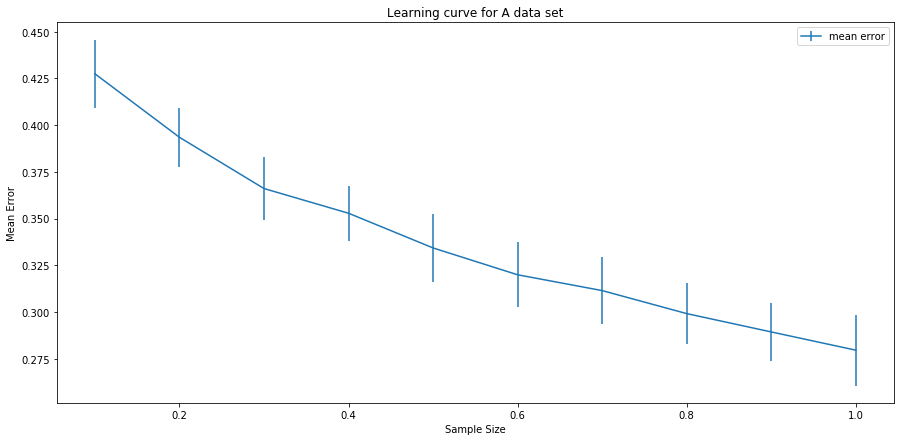

In [8]:
# Learning curve with sample size
# data set A
mean_error_A = errors_lgr[:int(len(errors_lgr)/2)]
mean_err_fold_A, std_fold_A = model_statics_calculation(mean_error_A)
learning_curve(mean_err_fold_A, std_fold_A, "A")


discussion: the above plot shows the learning curve for data set A using logistic regression. As the sample size increases the mean error(missmatch error) starts to come down rapidly, which shows the expected trend from literature of the model. The bars in the plot shows the standard deviation of mean error calculated for each subset of data set. Mean error starts abour 0.425 on a 10 percent of data set and reduces to 0.275 when complete data is used. The initial standard deviation for 10 percent sample size is 0.0229 which reduces to 0.0199 at 100% sample size. This shows that the model becomes more effiective with increase in number of examples but the rate of decrease of error reduces as well witht he increase in number of examples, so we should have an optimum number of examples.

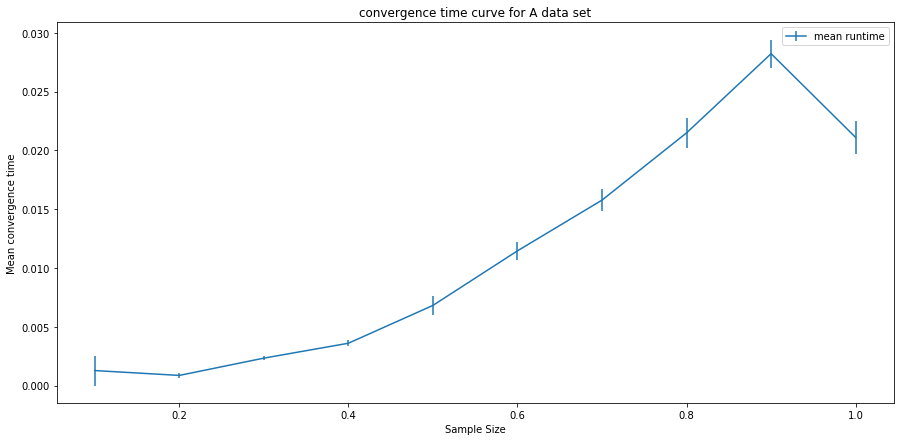

In [9]:
# convergence time plot with sample size
run_time_lgr_A = run_time_lgr[:int(len(run_time_lgr)/2)]
mean_runtime_A, std_runtime_A = model_statics_calculation(run_time_lgr_A)
runtime_curve(mean_runtime_A, std_runtime_A, "A")

discussion: the plot above shows the mean convergence time for each subset of data set. the bars in the graph shows the standard deviation for the convergence time. The trend shows that as the number of examples are increased the convergence time also increases( though very minutely and insignificantly). the times are given in seconds. for 0.1 sample size, mean of convergence time is 0.00154 secs, and for 1 sample size, it is 0.222 secs.

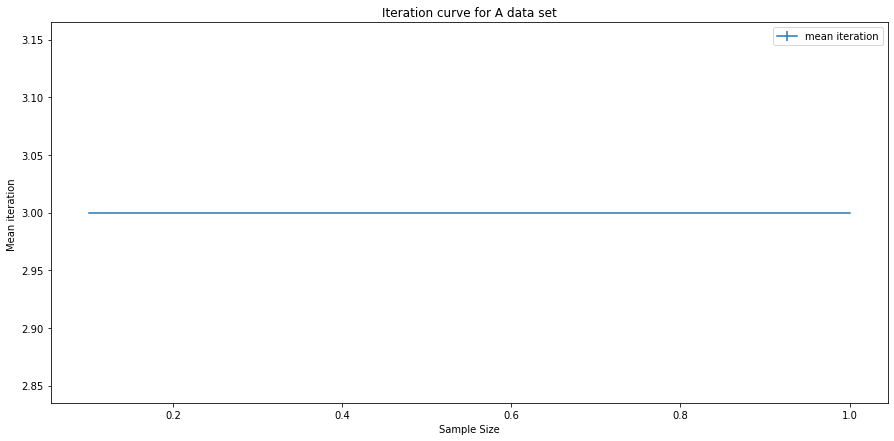

In [10]:
iterations_lgr_A = iterations_lgr[:int(len(iterations_lgr)/2)]
mean_iteration_A, std_iteration_A = model_statics_calculation(iterations_lgr)
iteration_curve(mean_iteration_A, std_iteration_A, "A")

Discussion: Though the convergence time increase with the increase in sample size but the number of iteration to converge remained same. For all subset of data set, on average it took 3 iterations to converge as evident from the plot.

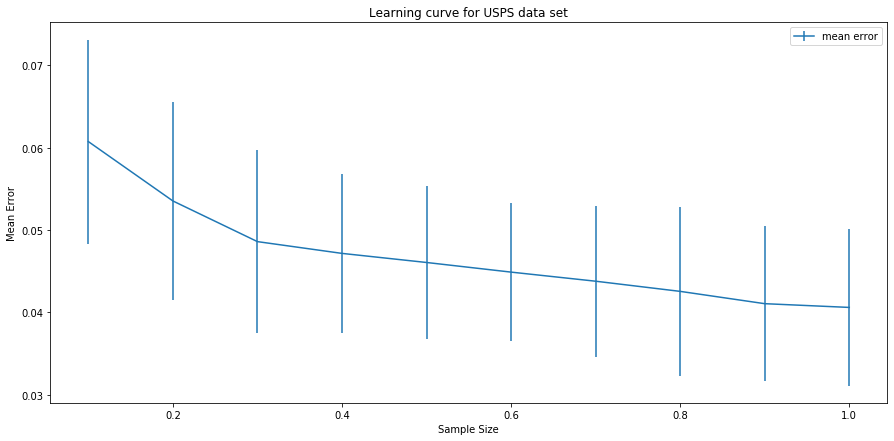

In [9]:
# Learning curve with sample size
#data set USPS
error_usps = errors_lgr[int(len(errors_lgr)/2):]
mean_err_fold_usps, std_fold_usps = model_statics_calculation(error_usps)
learning_curve(mean_err_fold_usps, std_fold_usps, "USPS")


discussion: the above plot shows the learning curve for data set USPS using logistic regression. As the sample size increases the mean error(missmatch error) starts to come down rapidly, which shows the expected trend from literature of the model. The bars in the plot shows the standard deviation of mean error calculated for each subset of data set. Mean error starts abour 0.0575 on a 10 percent of data set and reduces to 0.04 when complete data is used. The initial standard deviation for 10 percent sample size is 0.0104 which reduces to 0.007 at 100% sample size. This shows that the model becomes more effiective with increase in number of examples but the rate of decrease of error reduces as well witht he increase in number of examples, so we should have an optimum number of examples.

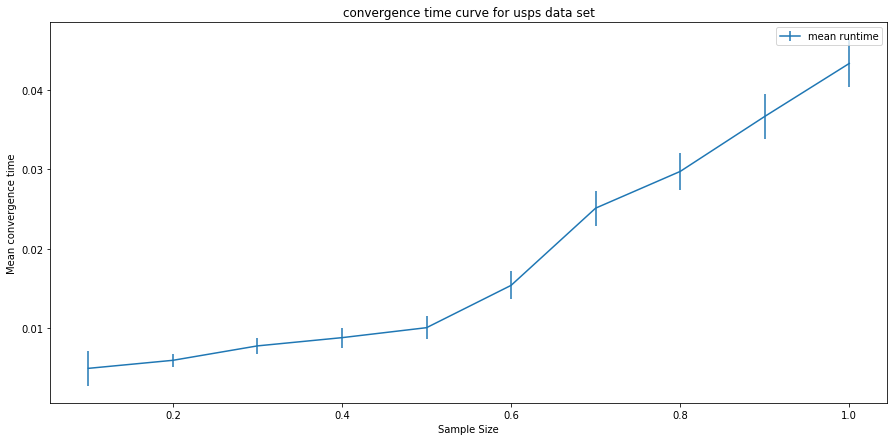

In [9]:
# run time plot with sample size
run_time_lgr_usps = run_time_lgr[int(len(run_time_lgr)/2):]
mean_runtime_usps, std_runtime_usps = model_statics_calculation(run_time_lgr_usps)
runtime_curve(mean_runtime_usps, std_runtime_usps, "usps")

discussion: the plot above shows the mean convergence time for each subset of data set. the bars in the graph shows the standard deviation for the convergence time. The trend shows that as the number of examples are increased the convergence time also increases( though very minutely and insignificantly). the times are given in seconds. for 0.1 sample size, mean of convergence time is 0.00467 secs, and for 1 sample size, it is 0.0442 secs.

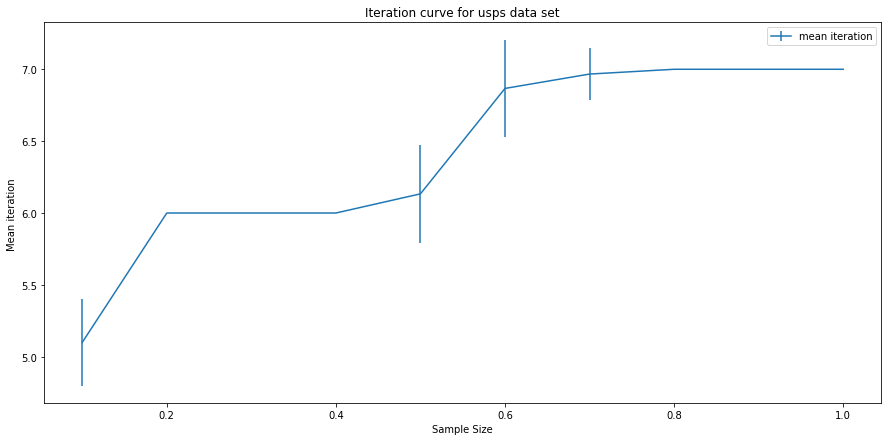

In [10]:
iterations_lgr_usps = iterations_lgr[int(len(iterations_lgr)/2):]
mean_iteration_usps, std_iteration_usps = model_statics_calculation(iterations_lgr_usps)
iteration_curve(mean_iteration_usps, std_iteration_usps, "usps")

Discussion: The USPS data set has 60 features and which is evident in the number of interations taken for convergence. As the sample size increase from 10% to 100% the mean number of iterations to converge increased from 5.1 to 7 iterations. The large number of data with features increases the time for convergence as well as the nubmer of iterations.

# Poisson regression prediction and plot

In [11]:
# getting data
data_matrix_p = pd.read_csv("AP.csv", header = None)
labels_p = pd.read_csv("labels-AP.csv", header = None)

run_time_poi = list()
iterations_poi = list()
abs_errors_poi = list()
     
#combining data and labels to randomize
data_and_labels_p = np.concatenate((data_matrix_p, labels_p), axis=1)

####### prediction and calculation part ########

# repeating the process 30 times.
for i in range(30):    
    # Call randomise_and_split to get randomised splitted data.
    test_label_p, test_data_p, train_label_p, train_data_p = randomise_and_split(data_and_labels_p)

    # divide this data into 10 subsets 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
    step_p = int(len(train_data_p)/10)+1
    for x in range(step_p, len(train_data_p)+step_p, step_p ):
        poisson = GLM(train_data_p[:x], train_label_p[:x], 10, "poisson", test_label_p, test_data_p )
        # getting W_map, number of iteration and convergence time 
        w_map_p, iterr_p, running_time_p = poisson.newton_raphson()
        run_time_poi.append(running_time_p)
        iterations_poi.append(iterr_p)
        # Do prediction using W_map.
        error = poisson.predict(w_map_p)
        abs_errors_poi.append(error)
    

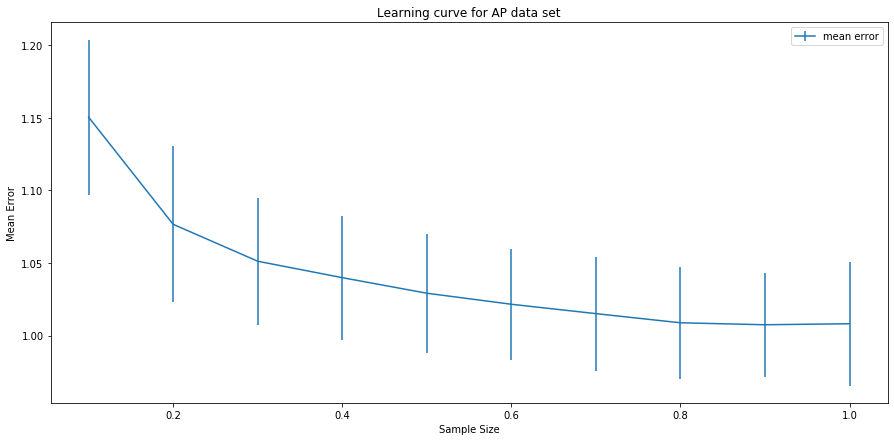

In [12]:
# learning curve plot with sample size
mean_err_fold_AP, std_fold_AP = model_statics_calculation(abs_errors_poi)
learning_curve(mean_err_fold_AP, std_fold_AP, "AP")


discussion: the above plot shows the learning curve for data set AP using Poisson regression. As the sample size increases the mean error(absolute difference error) starts to come down rapidly, which shows the expected trend from literature of the model. The bars in the plot shows the standard deviation of mean error calculated for each subset of data set. Mean error starts abour 1.1669 on a 10 percent of data set and reduces to 1.011 when complete data is used. The initial standard deviation for 10 percent sample size is 0.0559 which reduces to 0.0364 at 100% sample size. This shows that the model becomes more effiective with increase in number of examples but the rate of decrease of error reduces as well witht he increase in number of examples, so we should have an optimum number of examples.

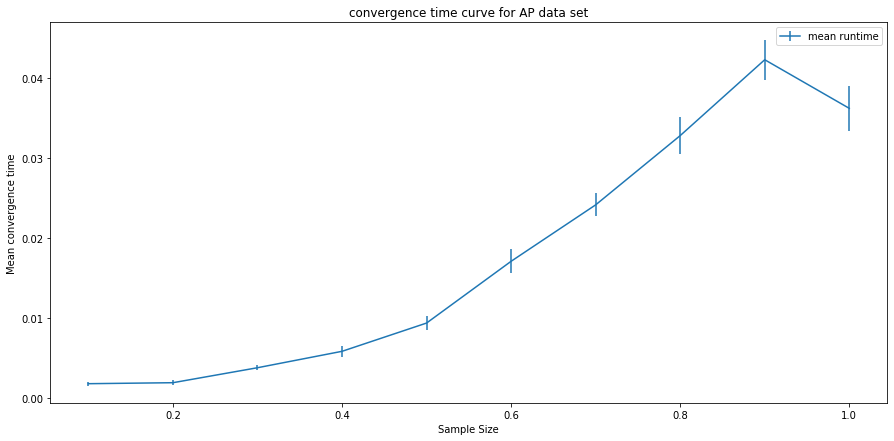

In [13]:
# run time plot with sample size
mean_runtime_AP, std_runtime_AP = model_statics_calculation(run_time_poi)
runtime_curve(mean_runtime_AP, std_runtime_AP, "AP")

discussion: the plot above shows the mean convergence time for each subset of data set. the bars in the graph shows the standard deviation for the convergence time. The trend shows that as the number of examples are increased the convergence time also increases( though very minutely and insignificantly). the times are given in seconds. for 0.1 sample size, mean of convergence time is 0.00186 secs, and for 1 sample size, it is 0.0367 secs.

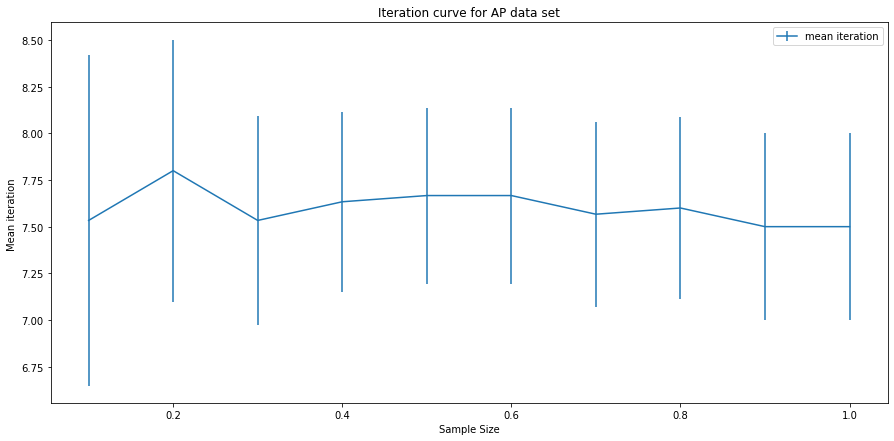

In [14]:
mean_iteration_AP, std_iteration_AP = model_statics_calculation(iterations_poi)
iteration_curve(mean_iteration_AP, std_iteration_AP, "AP")

Discussion: The mean number of iteration is more or less consistent througout the experiment but with high standard deviation as compared to other models( the variation is throughout suggesting randomization and dependence on examples.), which shows the the model took more iteration for converge when data was randomised, which directly indicate that the number of iteration poisson regression takes to converge has direct relevance to the examples given for particualt iteration of the model. for 0.1 sample size, the mean iteration is 7.2 and for 100 % sampel size, it is 7.3.

# Ordinal Regression prediction and plot

In [15]:
# getting data
data_matrix_o = pd.read_csv("AO.csv", header = None)
labels_o = pd.read_csv("labels-AO.csv", header = None)

run_time_ord = list()
iterations_ord = list()
abs_errors_ord0 = list()
     
#combining all data
data_and_labels_o = np.concatenate((data_matrix_o, labels_o), axis=1)

####### prediction and calculation part ########

# repeating the process 30 times.
for i in range(30):    
    # Call randomise_and_split to get randomised splitted data.
    test_label_o, test_data_o, train_label_o, train_data_o = randomise_and_split(data_and_labels_o)

    # divide this data into 10 subsets 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.
    step_o = int(len(train_data_o)/10)+1
    for x in range(step_o, len(train_data_o)+step_o, step_o ):
        ordinal = GLM(train_data_o[:x], train_label_o[:x], 10, "ordinal", test_label_o, test_data_o )   
    # getting W_map, number of iteration and convergence time 
        w_map_o, iterr_o, running_time_o = ordinal.newton_raphson(s=1)
        run_time_ord.append(running_time_o)
        iterations_ord.append(iterr_o)
        # Do prediction using W_map.
        error_ = ordinal.predict(w_map_o)
        abs_errors_ord0.append(error_)
        abs_errors_ord = [x[0] for x in abs_errors_ord0]


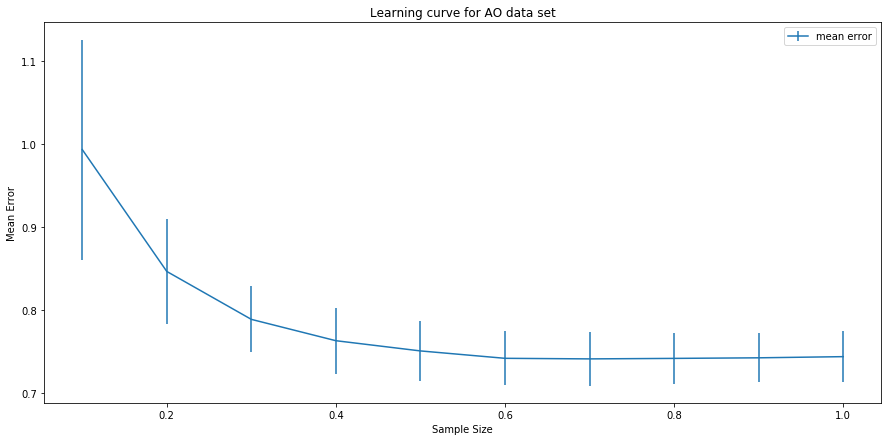

In [16]:
# learning curve plot with sample size
mean_err_fold_AO, std_fold_AO = model_statics_calculation(abs_errors_ord)
learning_curve(mean_err_fold_AO, std_fold_AO, "AO")

discussion: the above plot shows the learning curve for data set AO using Ordinal regression. As the sample size increases the mean error(absolute difference error) starts to come down rapidly, which shows the expected trend from literature of the model. The bars in the plot shows the standard deviation of mean error calculated for each subset of data set. Mean error starts abour 1.0284 on a 10 percent of data set and reduces to 0.7439 when complete data is used. The initial standard deviation for 10 percent sample size is 0.1083 which reduces to 0.0182 at 100% sample size. This shows that the model becomes more effiective with increase in number of examples but the rate of decrease of error reduces as well witht he increase in number of examples, so we should have an optimum number of examples.

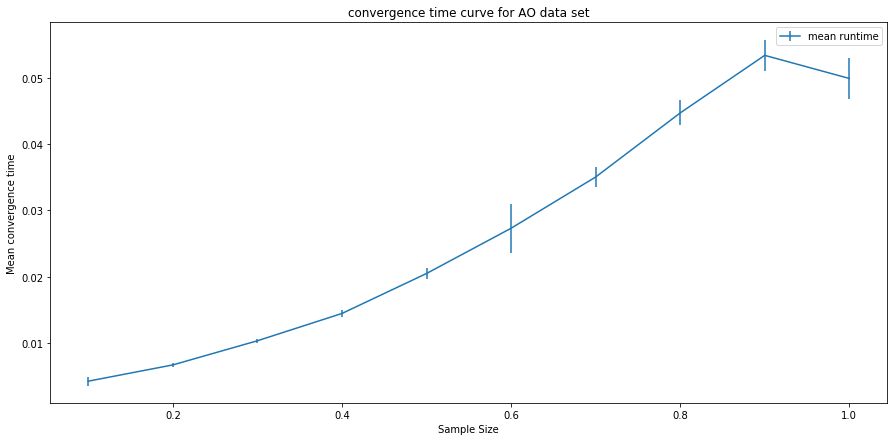

In [17]:
# run time plot with sample size
mean_runtime_AO, std_runtime_AO = model_statics_calculation(run_time_ord)
runtime_curve(mean_runtime_AO, std_runtime_AO, "AO")

discussion: the plot above shows the mean convergence time for each subset of data set. the bars in the graph shows the standard deviation for the convergence time. The trend shows that as the number of examples are increased the convergence time also increases( though very minutely and insignificantly). the times are given in seconds. for 0.1 sample size, mean of convergence time is 0.00424 secs, and for 1 sample size, it is 0.051 secs.

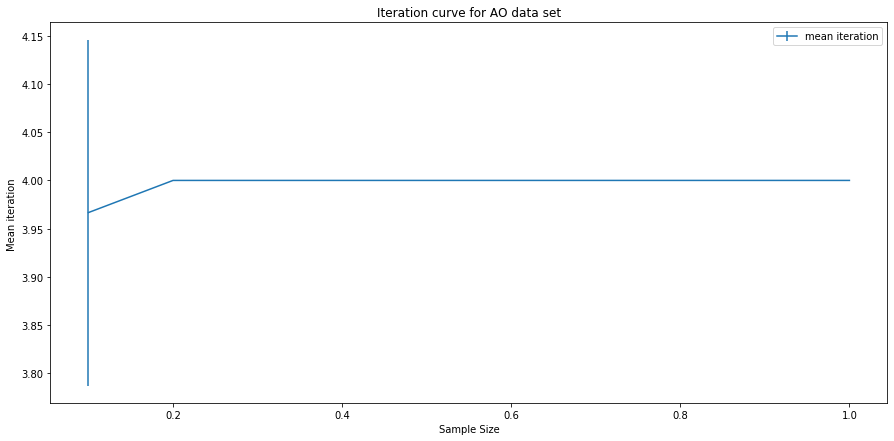

In [18]:
mean_iteration_AO, std_iteration_AO = model_statics_calculation(iterations_ord)
iteration_curve(mean_iteration_AO, std_iteration_AO, "AO")

Discussion: The mean number of iteration has remained consistent throughout the experiment, with a little variation during the 0.1 samle size. the mean value for 0.1 sample is 3.96 and for all other sample size its 4.

Other questions asked in PP3.

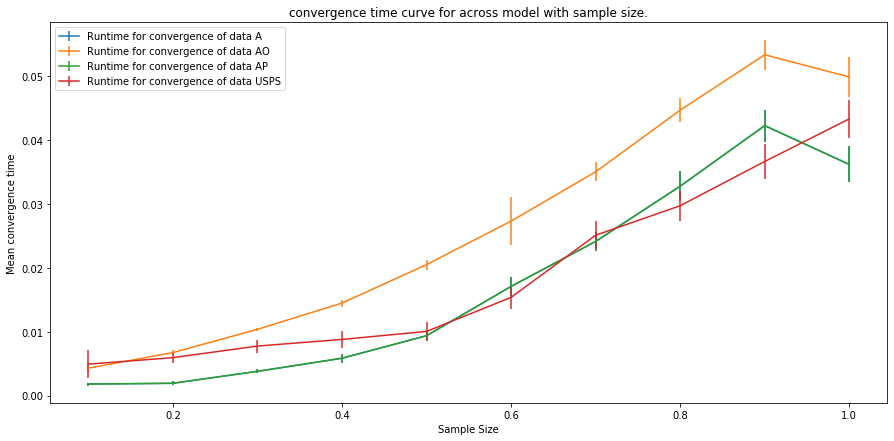

In [19]:
# Run time curve across model
means_times = [mean_runtime_AP, mean_runtime_AO, mean_runtime_AP, mean_runtime_usps]
std_times = [std_runtime_AP, std_runtime_AO, std_runtime_AP, std_runtime_usps]
method = ["A", "AO", "AP", "USPS"]
across_model_curve(means_times, std_times, method)

Question: How does learning time vary across datasets for classification and across the likelihood models?  

This plot shows the learning time(convergence time) for each Model, where, data set A and USPS has been modelled through Logistic regression, data set AP has been used with Poisson regression and data set AO has been used with Ordinal regression. The learning time plot for all models has been shown above (see other plots above for details about convergence time for each model), and it is evident that the for subset of examples varying from 0.1, 0.2, 0.3 to 1, Ordinal regression takes the most time to converge for almost all size of data. for USPS data, logistic regression takes lesser and lesser time as the nubmer of examples increses for it as compared to poisson regression on data AP and logistic regression on data A. The run time for logistic on data set A and poisson for data AP, traces each other closely. As per our experiement with the methodology and models, Ordinal regression takes more time to learn (also depends on data type, size and number of examples for each example and number of labels) and logistic and poisson are more comparable and vary in learning time for different data sets, indicating the learning time is highly dependent on the type of data provided as well as the number of examples in the data set.

For multiclass classification, we have used poisson and ordinal regression, it is clearly evident from the above plot that poisson regression is much faster as compared to ordianl regression, offcourse this will also depend on nubmer and type of examples for each example and implementation of model.

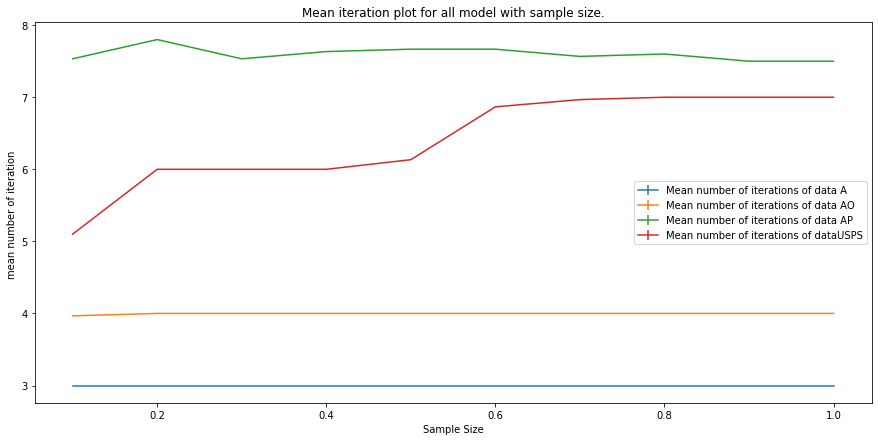

In [20]:
means_iteration = [mean_iteration_A, mean_iteration_AO, mean_iteration_AP, mean_iteration_usps]
std_times = 0
method = ["A", "AO", "AP", "USPS"]
across_model_iteration_curve(means_iteration, std_times, method)

Question: What are the main cost affecting these( time per iteration, number of iteration)?
    
Time per iteration: As shown in the abouve graphs it varyies from model to model and depending upon number of examples, type of data set ( might also depend on number of features and number of labels) for all model. it also depends on the implementatin of model to model. time per iteration also depends on the sample size which is provided during experiment, throughout our experiment across all modesl we have seen that the the time per iteration has increases with the increase in smaple size.

Number of iteration: number per iteration has also varied across model depending upon the sample size. As the plot suggests, the number of iteration is mainly the funtion of models and might depend on implementation of model.